In [2]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [3]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures', 'sfp_model', 'results_2D')
lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi','dset']

# NSD 
## model

In [4]:
pt_file_list = []
dset = 'nsdsyn'
for subj, roi in itertools.product(nsd_subj_list, ['V1','V2','V3']):
    file_name = os.path.join(results_dir, dset, f'model-params_lr-{lr}_eph-{max_epoch}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

## NSD precision

In [5]:
nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

# Broderick et al
## model

In [6]:
pt_file_list = []
dset = 'broderick'
tfunc_types=['corrected']
for subj, roi, tfunc in itertools.product(broderick_subj_list, ['V1'], tfunc_types):
    file_name = os.path.join(results_dir, dset, f'tfunc-{tfunc}_model_lr-{lr}_eph-{max_epoch}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D+['tfunc'])
broderick_params.replace({'tfunc': {'derick/tfunc corrected': 'corrected', 'derick/tfunc uncorrected': 'uncorrected'}}, inplace=True)

## broderick precision

In [7]:
broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
all_broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [8]:
broderick_df = all_broderick_df.query('tfunc == "corrected"')
broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = pd.concat((broderick_df, nsd_df), axis=0)

In [9]:
final_df['goal'] = final_df['vroinames'].apply(lambda x: 'Replication' if x == "V1" else 'Extension')
tmp = nsd_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
final_df = pd.concat((tmp, final_df), axis=0)


# Plot parameter estimates

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


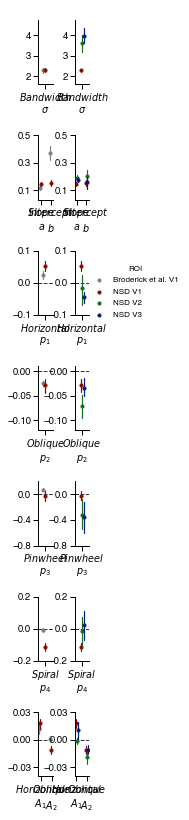

In [10]:
params_list = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
group = [1,2,2,3,4,5,6,7,7]
fig_name_2 = f'fig-params_lr-{lr}_eph-{max_epoch}_dset-all_sub-all_roi-V1V2V3_vs-{vsc}.svg'
ylim_list = [(1.6, 4.75), (0.03, 0.5), (-0.1, 0.1),(-0.12, 0.01),(-0.8, 0.2),(-0.2, 0.2), (-0.04, 0.03)]
yticks_list = [[2, 3, 4], [0.1, 0.3, 0.5], [-0.1,0,0.1],[-0.1,-0.05,0], [-0.8, -0.4,0], [-0.2, 0, 0.2], [-0.03,0,0.03]]
a = [3,2,0]

roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))

grid = vis2D.plot_precision_weighted_avg_parameters_updated(final_df,
                                                    params_list,
                                                    group,
                                                    col='goal',
                                                    col_order=['Replication', 'Extension'],
                                                    hue='dset_type',
                                                    hue_order=['Broderick et al. V1',
                                                               'NSD V1', 'NSD V2', 'NSD V3'],
                                                    lgd_title='ROI',
                                                    height=1.8, width=1, 
                                                    pal=roi_pal,
                                                    dodge=0.25,
                                                    dot_scale=0.7,
                                                    ylim_list=ylim_list,
                                                    ytick_list=yticks_list,
                                                    save_path=os.path.join(fig_dir, 'all', 'params-avg_lr-0.0005_eph-30000_vs-pRFsize.svg'))

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


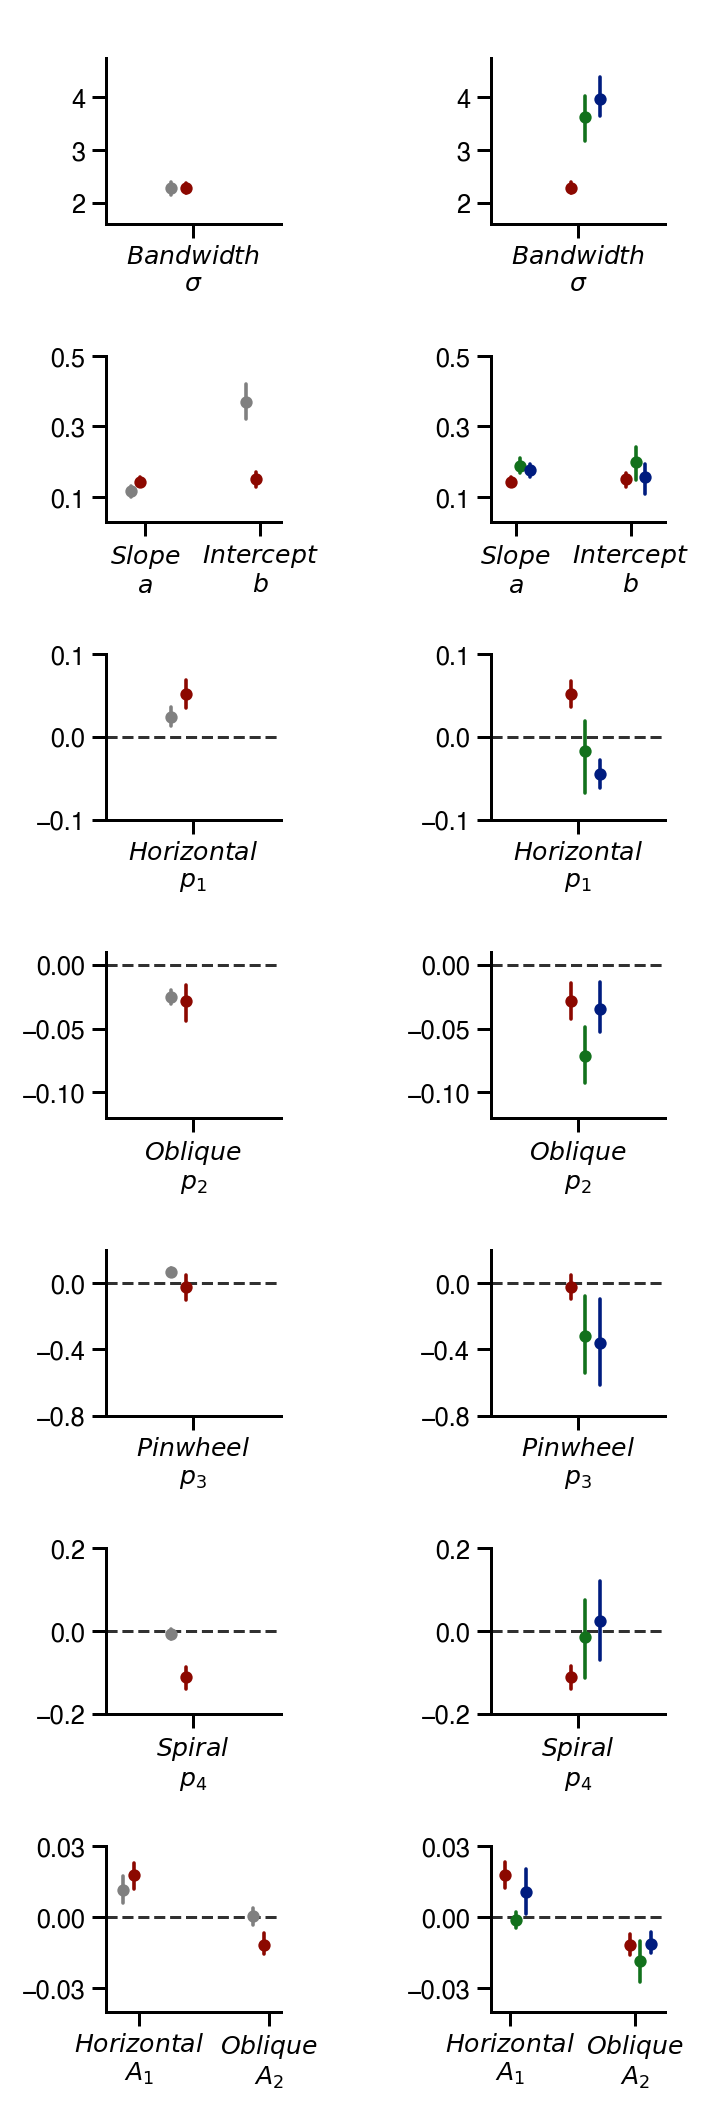

In [22]:
params_list = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
group = [1,2,2,3,4,5,6,7,7]
fig_name_2 = f'fig-params_lr-{lr}_eph-{max_epoch}_dset-all_sub-all_roi-V1V2V3_vs-{vsc}.svg'
ylim_list = [(1.6, 4.75), (0.03, 0.5), (-0.1, 0.1),(-0.12, 0.01),(-0.8, 0.2),(-0.2, 0.2), (-0.04, 0.03)]
yticks_list = [[2, 3, 4], [0.1, 0.3, 0.5], [-0.1,0,0.1],[-0.1,-0.05,0], [-0.8, -0.4,0], [-0.2, 0, 0.2], [-0.03,0,0.03]]
a = [3,2,0]

roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))

grid = vis2D.plot_precision_weighted_avg_parameters_updated(final_df,
                                                    params_list,
                                                    group,
                                                    col='goal',
                                                    col_order=['Replication', 'Extension'],
                                                    hue='dset_type',
                                                    hue_order=['Broderick et al. V1',
                                                               'NSD V1', 'NSD V2', 'NSD V3'],
                                                    lgd_title=None,
                                                    height=1.54, width=1.7, 
                                                    pal=roi_pal,
                                                    dodge=0.25,
                                                    dot_scale=0.7,
                                                    ylim_list=ylim_list,
                                                    ytick_list=yticks_list,
                                                    save_path=os.path.join(fig_dir, 'all', 'params-avg_lr-0.0005_eph-30000_vs-pRFsize.svg'))

In [34]:
df

,sub,lr_rate,max_epoch,vroinames,dset,precision,dset_type,goal,tfunc,params,value,group,value_and_weights
0,subj01,0.0005,30000,V1,nsdsyn,1.342082,NSD V1,Extension,NaN,sigma,2.490021,1,2.490021+1.342082j
1,subj02,0.0005,30000,V1,nsdsyn,0.758509,NSD V1,Extension,NaN,sigma,2.009928,1,2.009928+0.758509j
2,subj03,0.0005,30000,V1,nsdsyn,0.451902,NSD V1,Extension,NaN,sigma,2.529316,1,2.529316+0.451902j
3,subj04,0.0005,30000,V1,nsdsyn,1.112438,NSD V1,Extension,NaN,sigma,1.979350,1,1.979350+1.112438j
4,subj05,0.0005,30000,V1,nsdsyn,0.595493,NSD V1,Extension,NaN,sigma,2.611645,1,2.611645+0.595493j
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,subj07,0.0005,30000,V2,nsdsyn,0.585363,NSD V2,Extension,NaN,A_2,0.005095,7,0.005095+0.585363j
392,subj07,0.0005,30000,V3,nsdsyn,0.820911,NSD V3,Extension,NaN,A_2,-0.000384,7,-0.000384+0.820911j
393,subj08,0.0005,30000,V1,nsdsyn,0.421552,NSD V1,Replication,NaN,A_2,-0.018485,7,-0.018485+0.421552j
394,subj08,0.0005,30000,V2,nsdsyn,0.637120,NSD V2,Extension,NaN,A_2,-0.018921,7,-0.018921+0.637120j
